In [1]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_gt import *
from scripts.track_pairs import *

/home/s1803229/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Outliers in $\rho_v/\rho_g$ Estimation

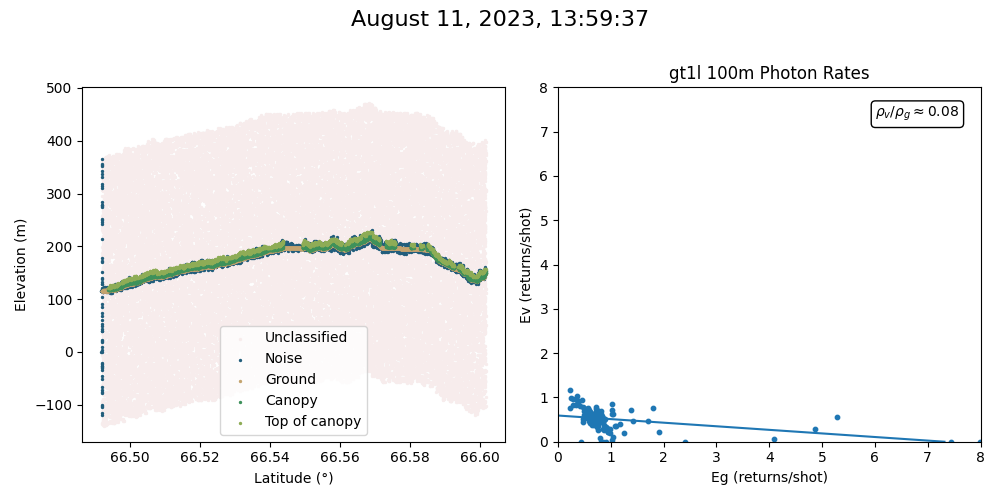

In [2]:
%matplotlib ipympl

dirpath = '../data/rovaniemi_w'
all_ATL03, all_ATL08 = track_pairs(dirpath)

N = 45
gt = 'gt1l'
atl03path = all_ATL03[N]
atl08path = all_ATL08[N]

pvpg_gt(atl03path, atl08path, gt)

### Segments with abnormally high $E_g$

In [3]:
atl03 = ATL03(atl03path, atl08path, gt)
atl08 = ATL08(atl08path, gt)
atl08.df[atl08.df.Eg > 4]

lat        lon          gh            ch    Ng  Nv        Eg  \
32  66.572678  25.250801  196.695724  3.402823e+38   580   0  4.084507   
58  66.549500  25.244070  196.332703  1.371860e+01   729  54  5.282609   
59  66.548607  25.243814  196.272919  3.402823e+38  1119   0  7.992857   
60  66.547714  25.243547  196.450684  3.402823e+38  1042   0  7.442857   
61  66.546822  25.243294  196.498062  3.402823e+38  1372   0  9.730496   
62  66.545937  25.243048  196.892670  3.402823e+38   675   0  4.856115   

          Ev  
32  0.070423  
58  0.557971  
59  0.000000  
60  0.000000  
61  0.000000  
62  0.294964

### Show location of relevant segments on a map

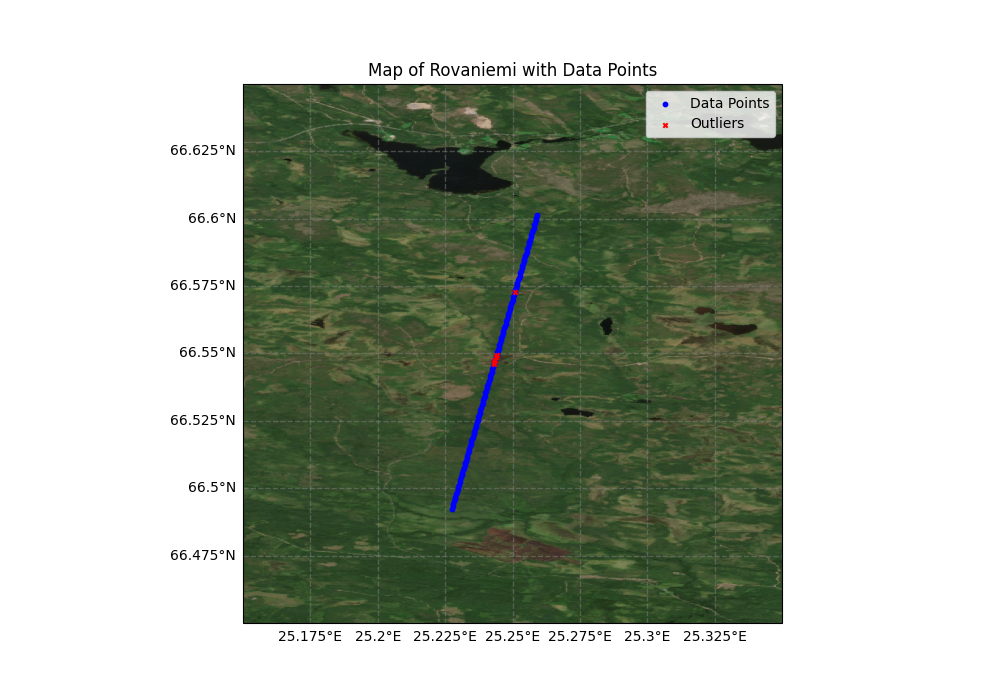

In [4]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# Sample DataFrame with latitude and longitude columns
# Replace this with your actual DataFrame
df = atl08.df.loc[:,['lat','lon']]
df_outlier = atl08.df[atl08.df.Eg > 4].loc[:,['lat','lon']]

# Create a map with Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize = (10,7))
ax.set_extent([25.15,25.35,66.45,66.65])  # Set the map extent to cover Edinburgh

# Plot points from the DataFrame
ax.scatter(df['lon'], df['lat'], color='b', marker='o', label='Data Points', zorder=3, s=10)
ax.scatter(df_outlier['lon'], df_outlier['lat'], color='r', marker='x', label='Outliers', zorder=4, s=10)

tif = rasterio.open(dirpath + '/rovaniemi_image.tiff')
show(tif, ax=ax, transform=ccrs.PlateCarree())

# Add labels, title, and legend
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Map of Rovaniemi with Data Points')
ax.legend()

# Add latitude and longitude gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=1, color='gray', alpha=0.5)
gl.top_labels = gl.right_labels = False  # Updated lines
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Show the plot
plt.show()

All the outliers occur on or partially on patches of darker marshland. The lighter marshland visible in the bottom left figure does not yield similar outliers. Instead of deleting the entries with arbitrarily large values of Ev, I changed the value of these entries to 0. The classified track above show segments with no canopy cover and the track plot shows that all problem entries occurred over such treeless spaces. Thus, I felt that this change was justified; it seems like more of a data entry issue that data collection issue.

<center><img src="../data/rovaniemi_w/marsh1.png" width=440> <img src="../data/rovaniemi_w/marsh2.png" width=400></center>

<center><img src="../data/rovaniemi_w/plot1.png" width=500> <img src="../data/rovaniemi_w/plot2.png" width=500></center>

### Penalized orthogonal distance regression



In [3]:
# from scripts.pvpg_gt_penalized import pvpg_gt_penalized

In [101]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scipy.optimize import least_squares

def parse_filename_datetime(filename):
    # Extracting only the filename from the full path
    filename_only = filename.split('/')[-1]
    date_str = filename_only.split('_')[2][:14]  # Extracting yyyymmddhhmmss part
    datetime_obj = datetime.strptime(date_str, '%Y%m%d%H%M%S')
    return datetime_obj.strftime('%B %d, %Y, %H:%M:%S')

def pvpg_gt_penalized(atl03path, atl08path, gt, s):

    i = 0


    try:
        atl03 = ATL03(atl03path, atl08path, gt)
    except (KeyError, ValueError, OSError) as e:
        # print('Sucks to suck.')
        return
    atl08 = ATL08(atl08path, gt)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    ax = axes.flatten()

    # Extracting date and time from the filename
    title_date = parse_filename_datetime(atl03path)

    # Set the figure title
    fig.suptitle(title_date, fontsize=16)

    atl03.plot(ax[i])

    def model(params, x):
        return params[0]*x + params[1]
        
    def residuals(params, x, y):
        return np.abs(model(params, x) - y)/np.sqrt(1 + params[0]**2)

    X = atl08.df.Eg
    Y = atl08.df.Ev
        
    initial_guess = [-1,(np.median(Y) + np.max(Y))]
    
    
    result = least_squares(residuals, initial_guess, loss='arctan', f_scale=s, args=(X, Y))
    
    a_opt, b_opt = result.x

    ax[i+1].set_title(f"{gt} 100m Photon Rates")
    ax[i+1].scatter(X, Y, s=10)
    ax[i+1].plot(np.array([-10,20]), model([a_opt, b_opt], np.array([-10,20])), label='Orthogonal Distance Regression', color='red', linestyle='--')
    ax[i+1].set_xlabel('Eg (returns/shot)')
    ax[i+1].set_ylabel('Ev (returns/shot)')
    ax[i+1].set_xlim(0,12)
    ax[i+1].set_ylim(0,12)
    ax[i+1].annotate(r'$\rho_v/\rho_g \approx {:.2f}$'.format(-a_opt),
                   xy=(.95,.95),
                   xycoords='axes fraction',
                   ha='right',
                   va='top',
                   bbox=dict(boxstyle="round,pad=0.3",
                             edgecolor="black",
                             facecolor="white"))

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the layout to make room for the suptitle
    plt.show()
    return

In [102]:
# %matplotlib ipympl

# dirpath = '../data/rovaniemi_w'
# all_ATL03, all_ATL08 = track_pairs(dirpath)

# N = len(all_ATL03)
# gt = 'gt1r'

# s = 0.01
# for i in range(N):
#     atl03path = all_ATL03[i]
#     atl08path = all_ATL08[i]
#     pvpg_gt_penalized(atl03path, atl08path, gt, s)

N = 0, s = 0.01


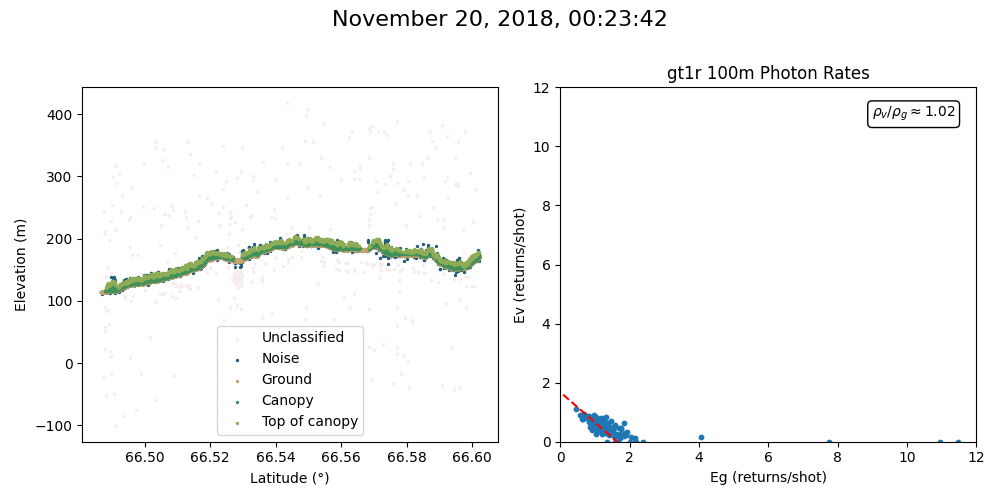

N = 0, s = 0.05


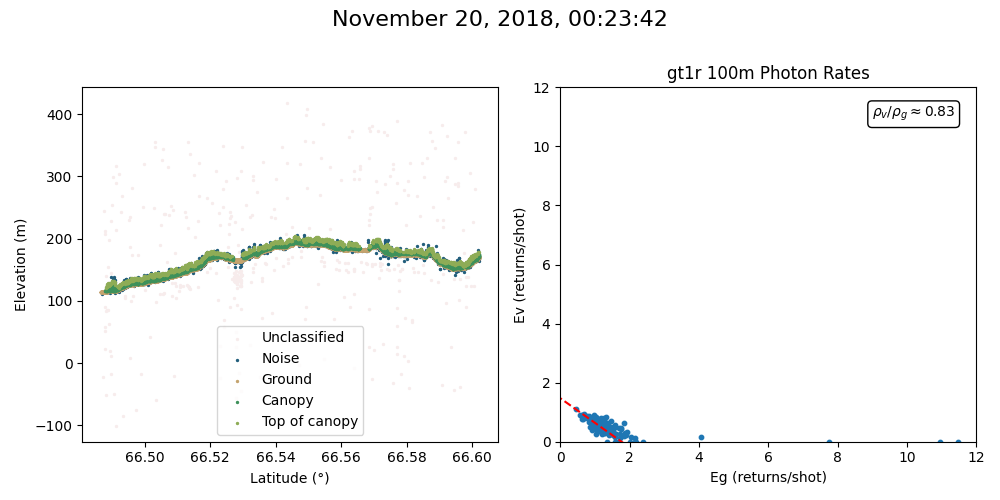

N = 0, s = 0.1


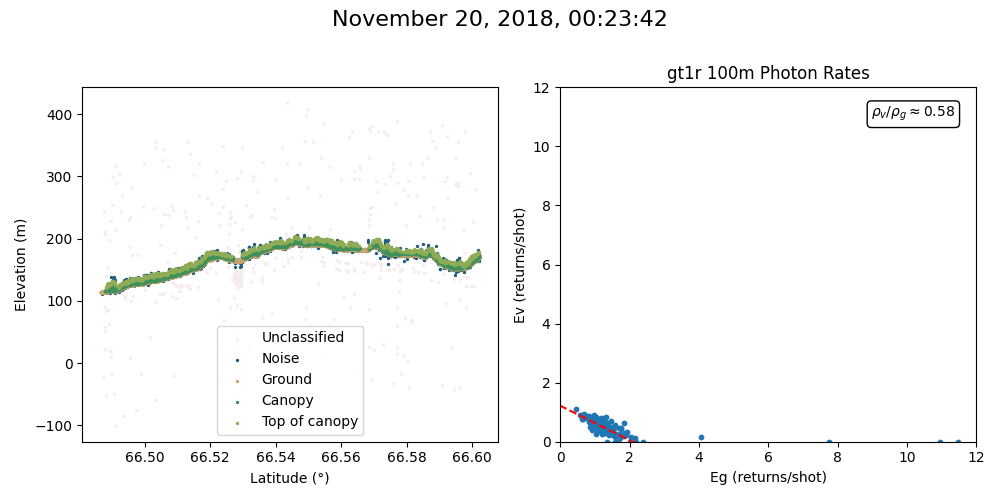

N = 1, s = 0.01
N = 1, s = 0.05
N = 1, s = 0.1
N = 2, s = 0.01


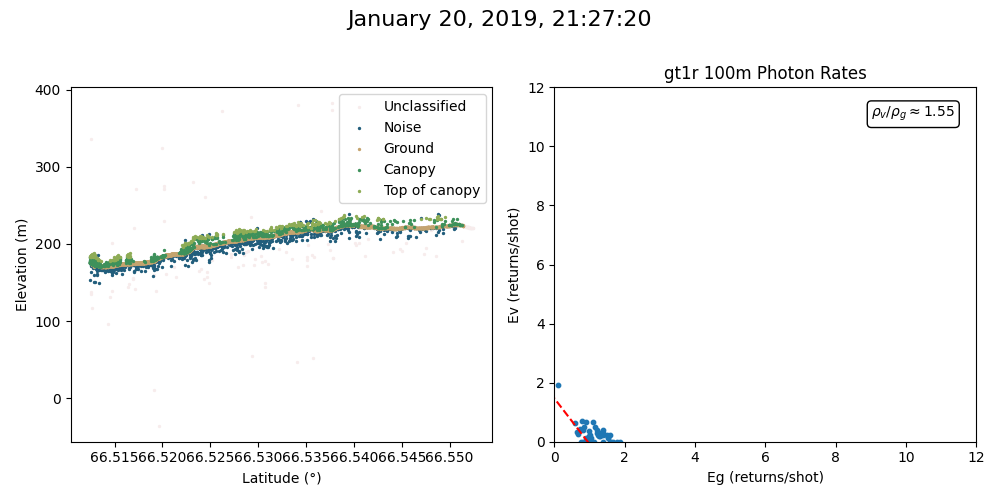

N = 2, s = 0.05


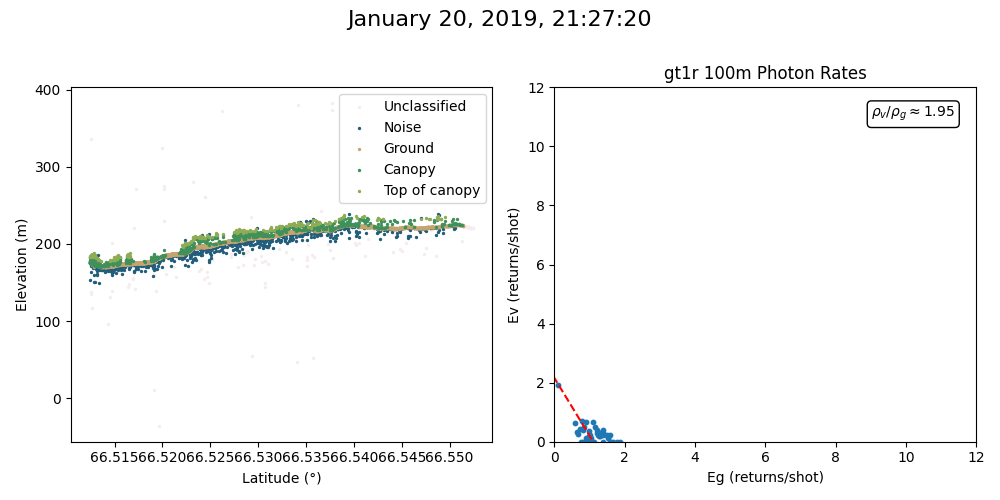

N = 2, s = 0.1


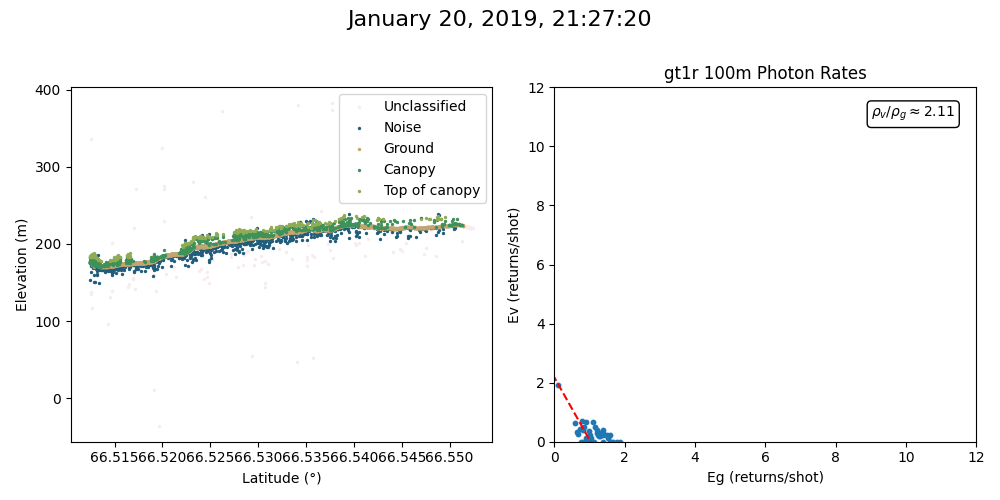

N = 3, s = 0.01


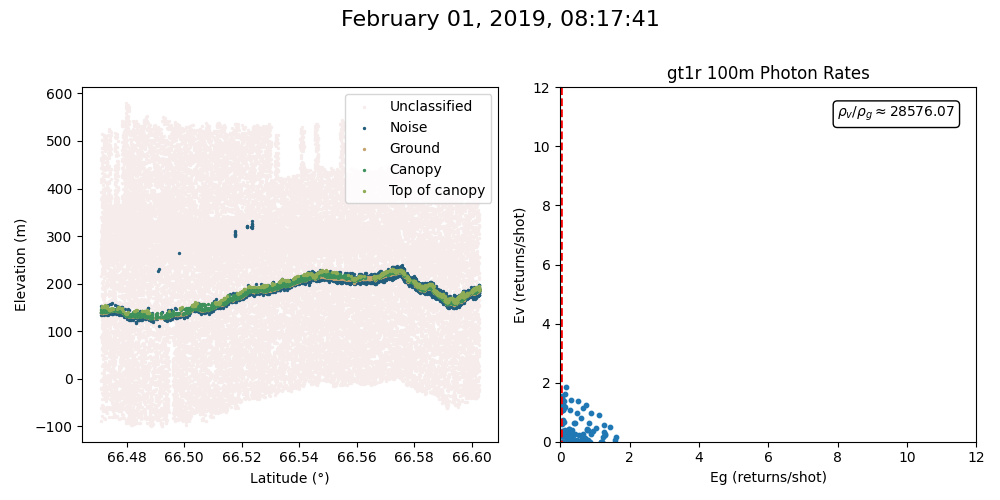

N = 3, s = 0.05


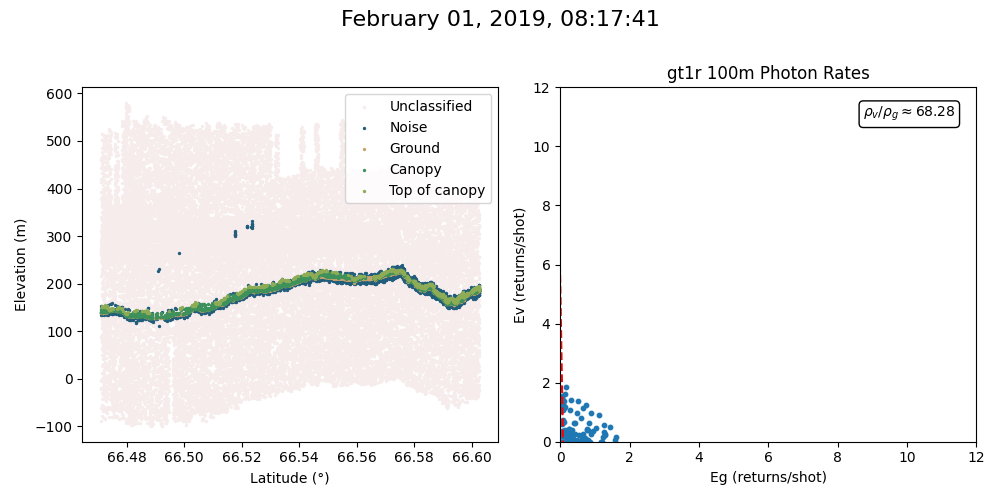

N = 3, s = 0.1


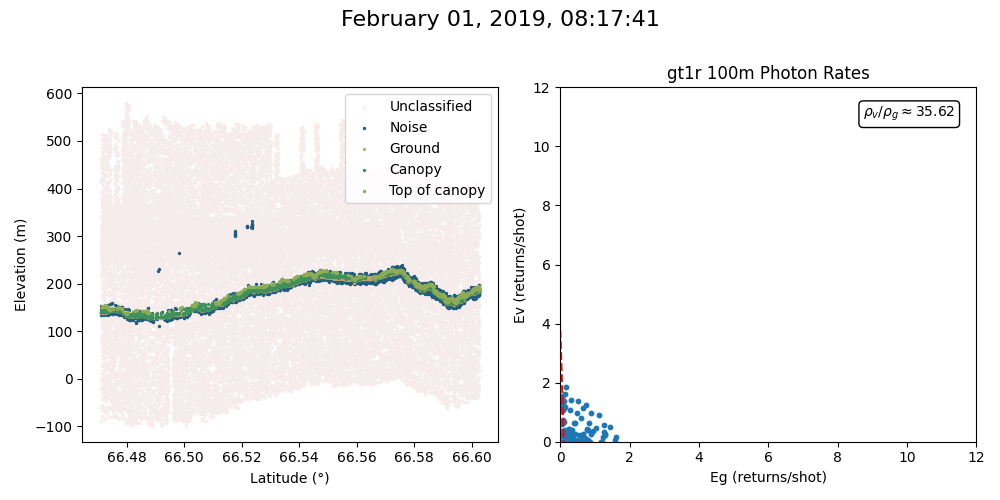

N = 4, s = 0.01
N = 4, s = 0.05
N = 4, s = 0.1
N = 5, s = 0.01


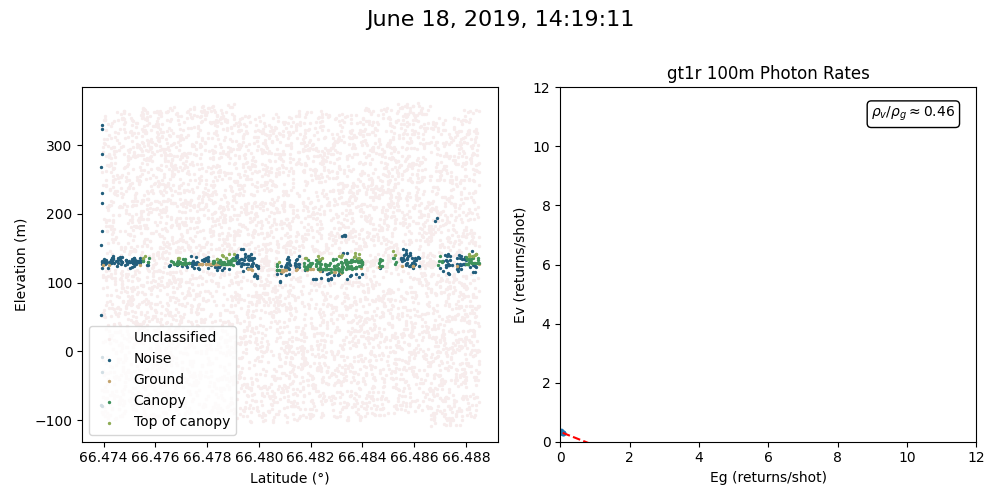

N = 5, s = 0.05


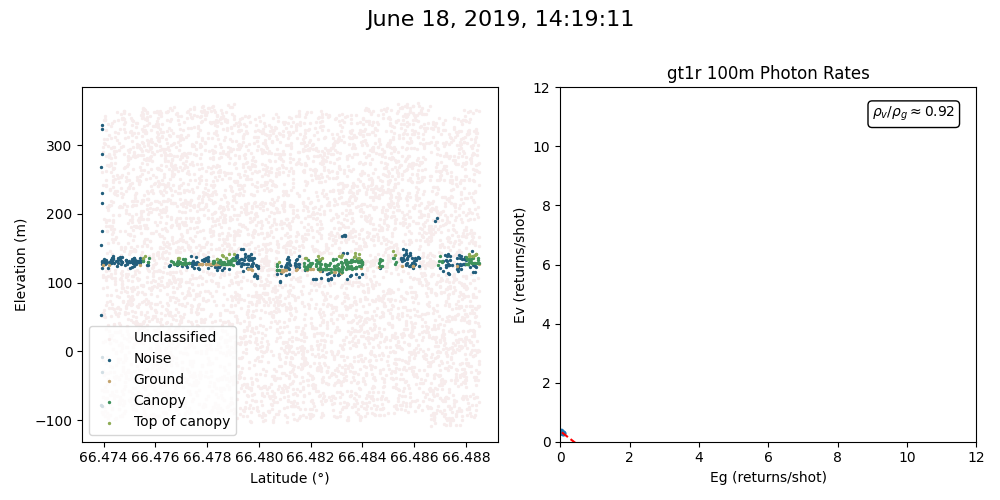

N = 5, s = 0.1


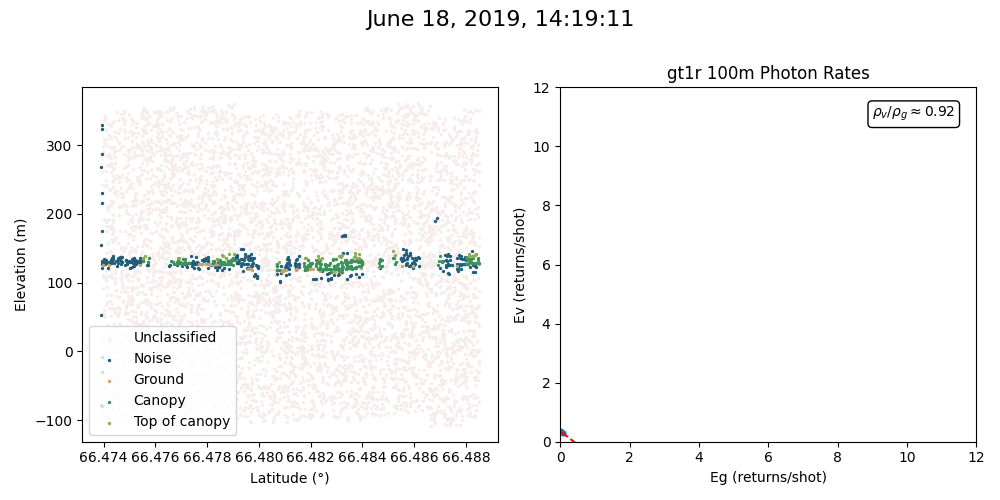

N = 6, s = 0.01


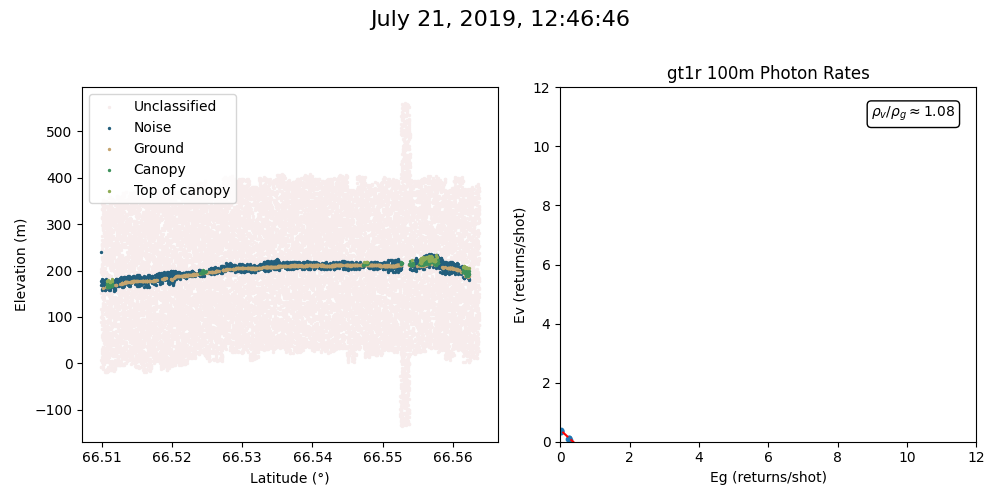

N = 6, s = 0.05


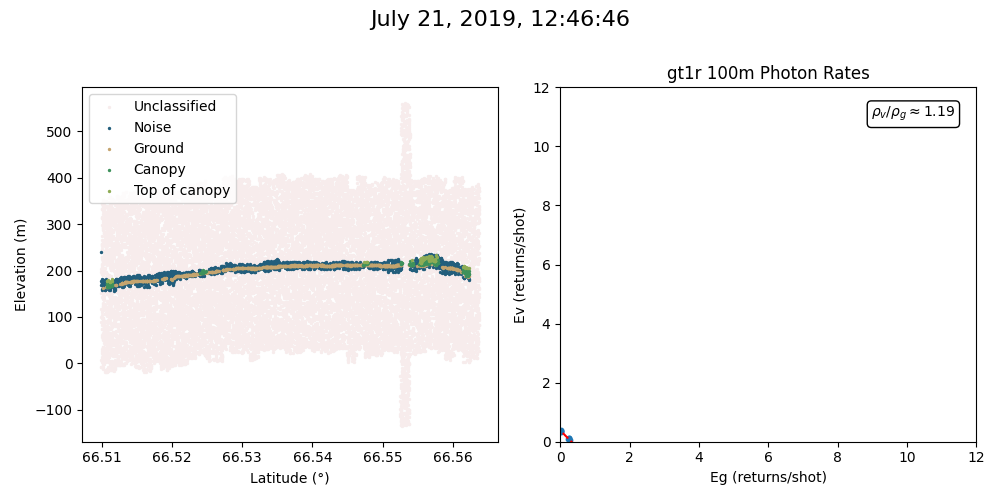

N = 6, s = 0.1


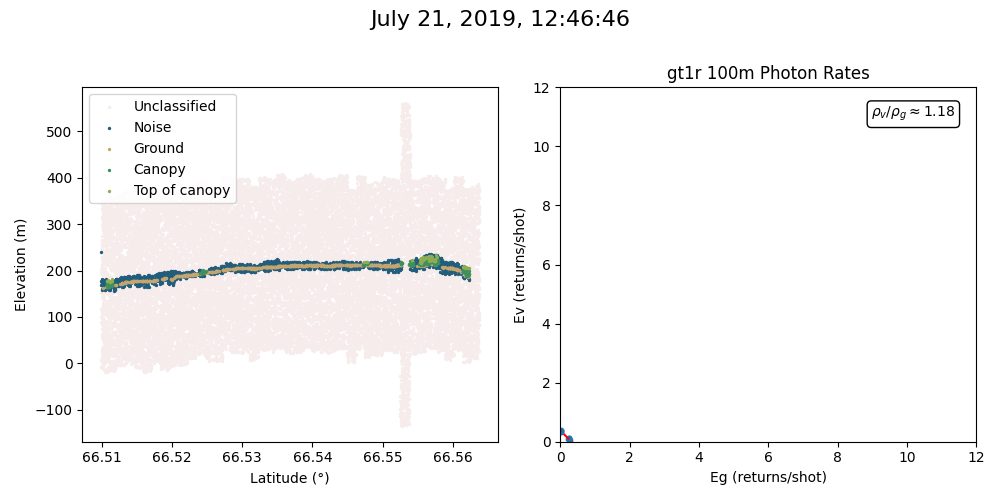

N = 7, s = 0.01
N = 7, s = 0.05
N = 7, s = 0.1
N = 8, s = 0.01


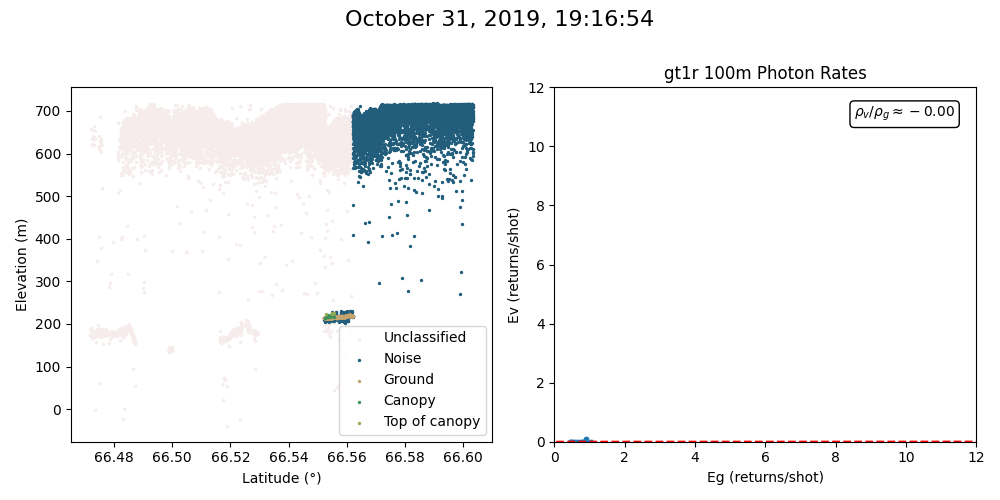

N = 8, s = 0.05


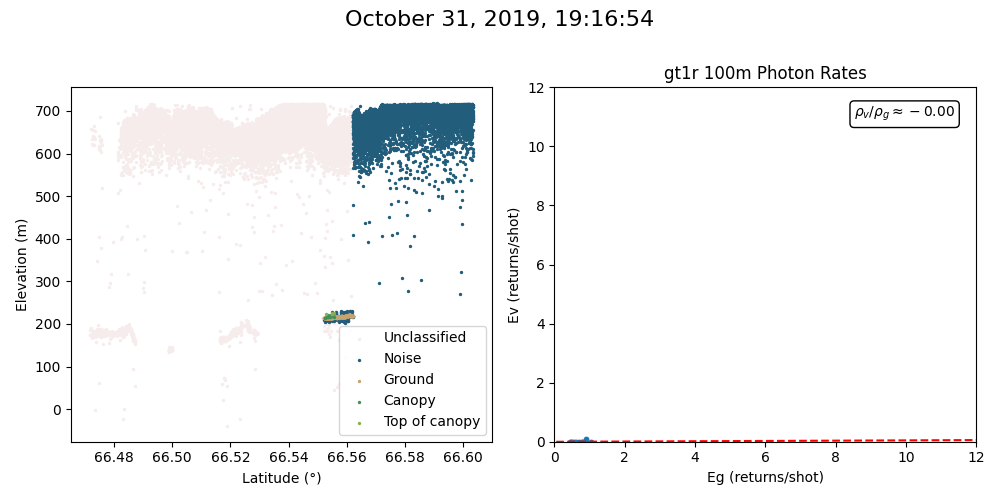

N = 8, s = 0.1


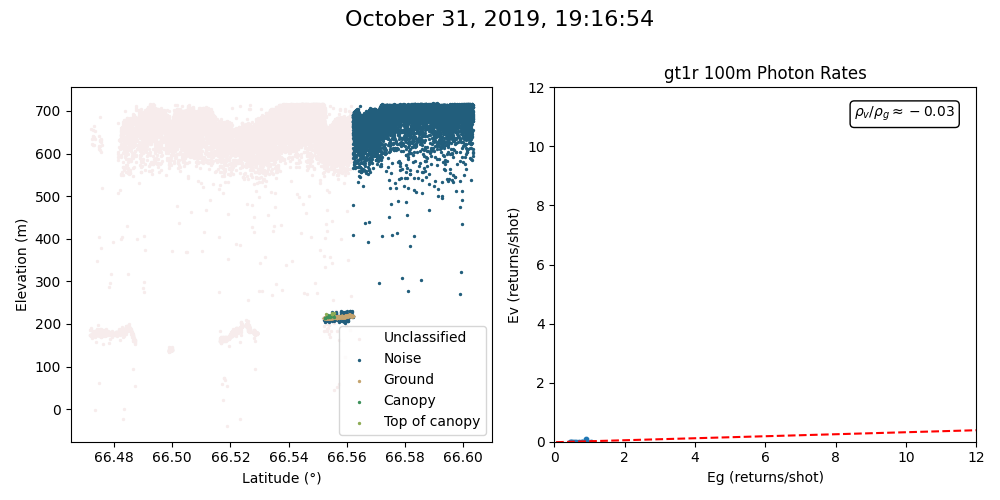

N = 9, s = 0.01
N = 9, s = 0.05
N = 9, s = 0.1
N = 10, s = 0.01


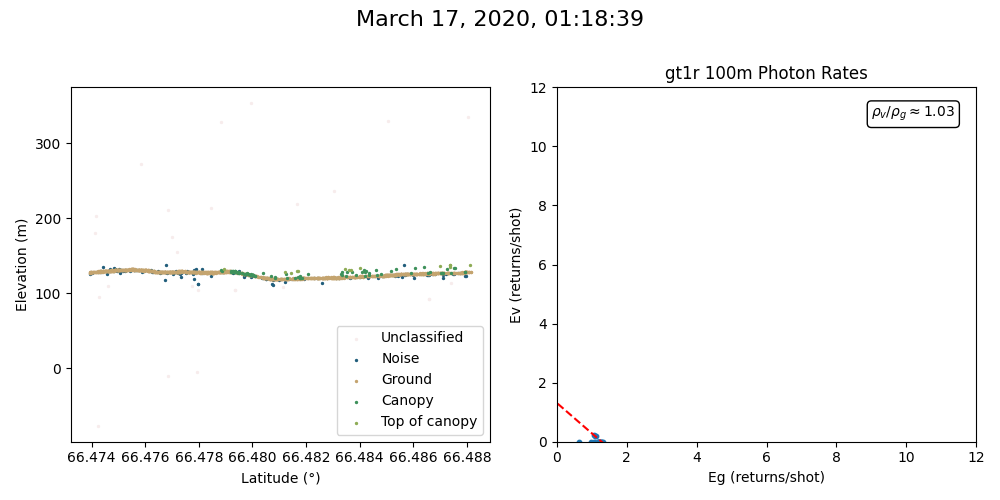

N = 10, s = 0.05


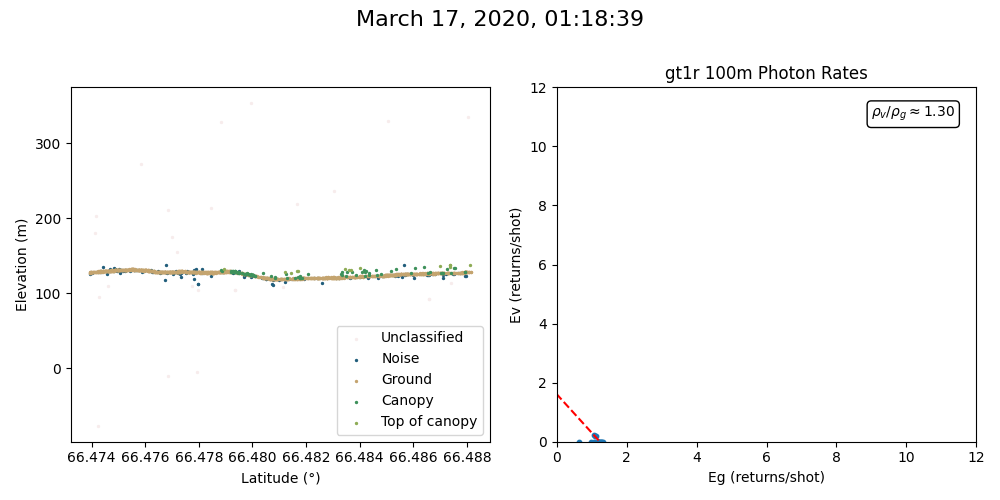

N = 10, s = 0.1


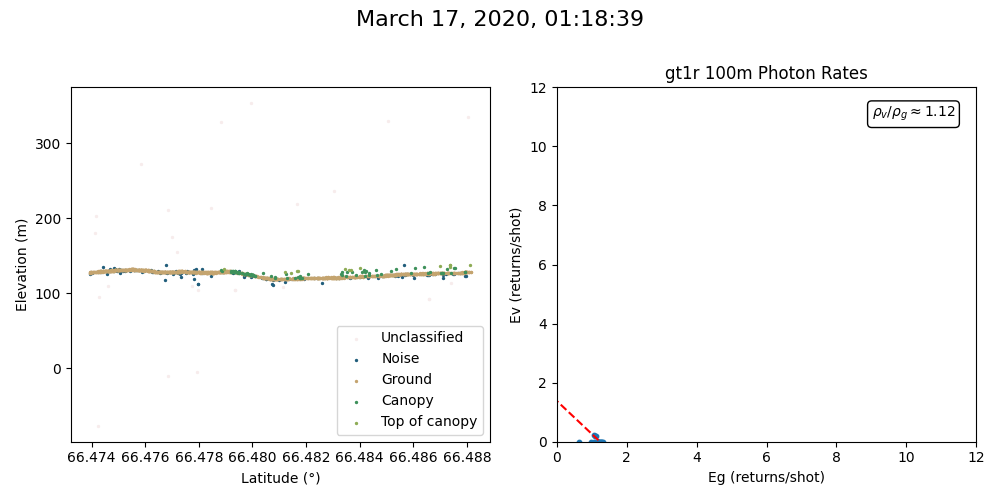

N = 11, s = 0.01
N = 11, s = 0.05
N = 11, s = 0.1
N = 12, s = 0.01


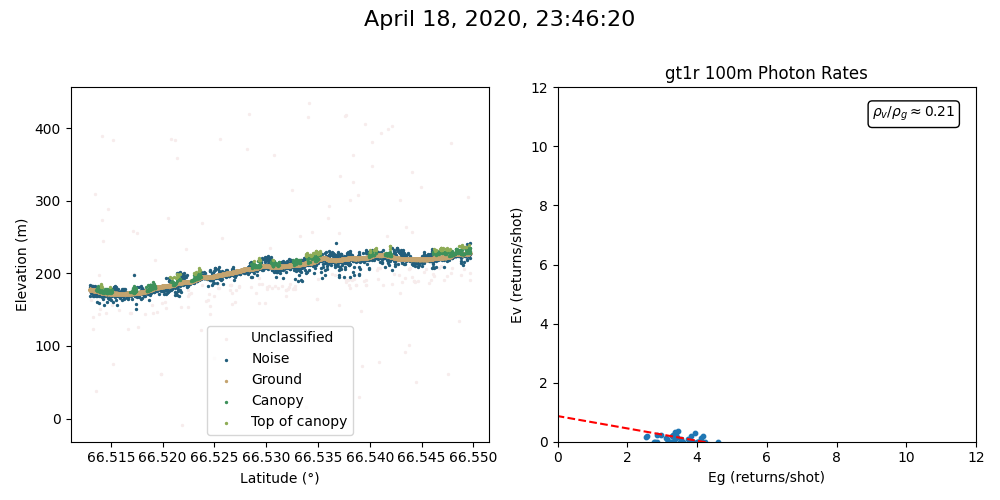

N = 12, s = 0.05


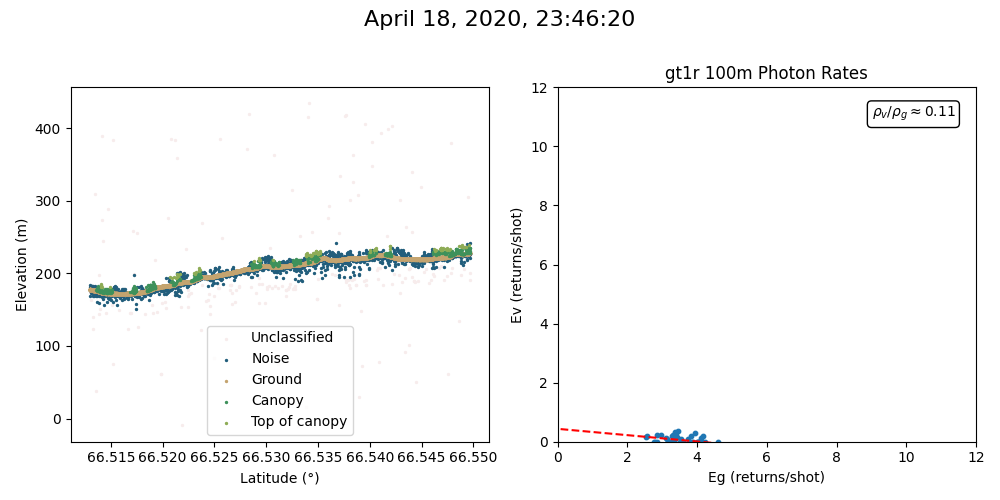

N = 12, s = 0.1


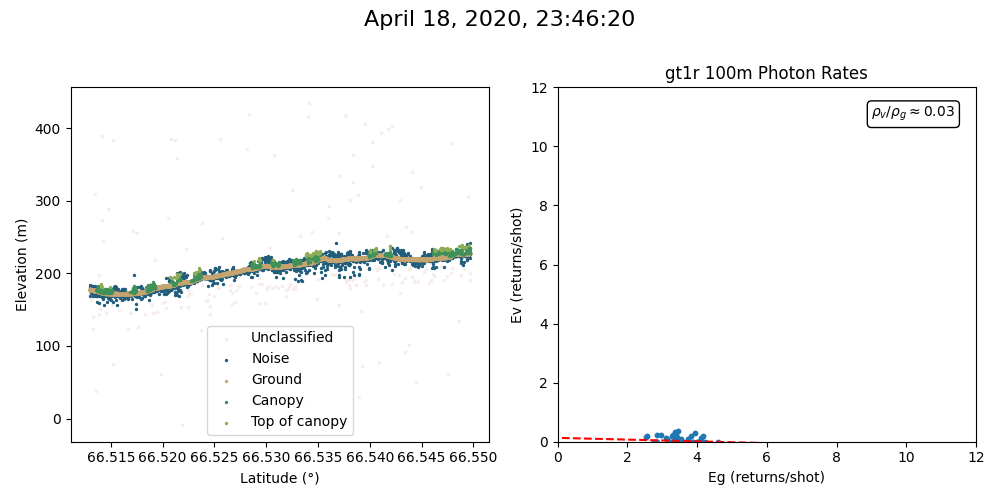

N = 13, s = 0.01


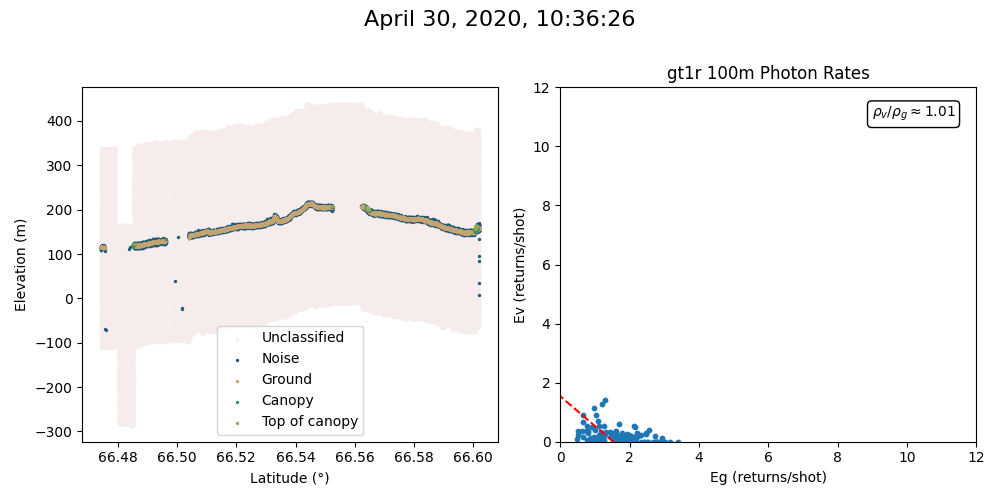

N = 13, s = 0.05


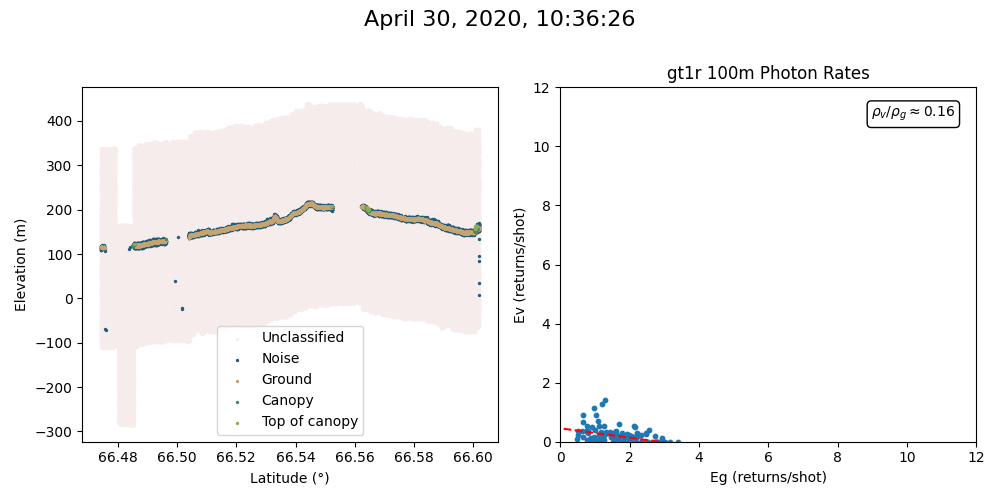

N = 13, s = 0.1


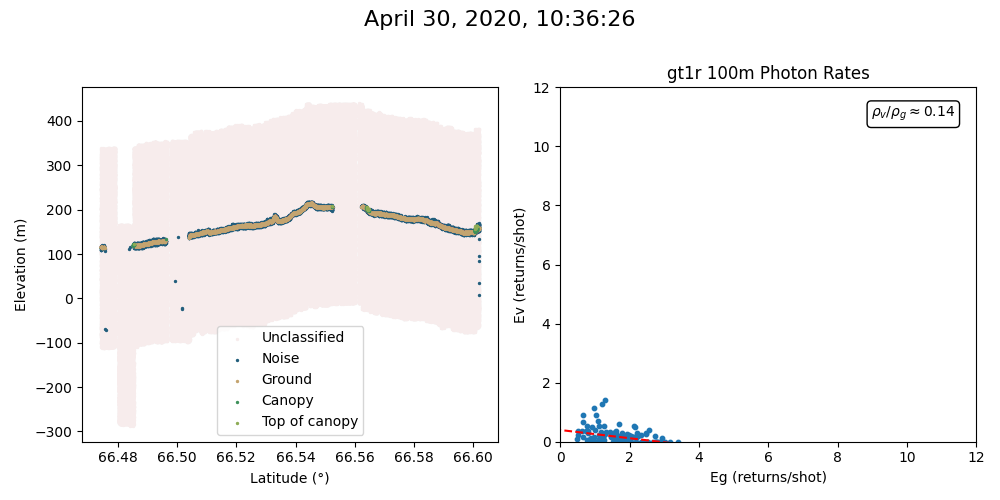

N = 14, s = 0.01


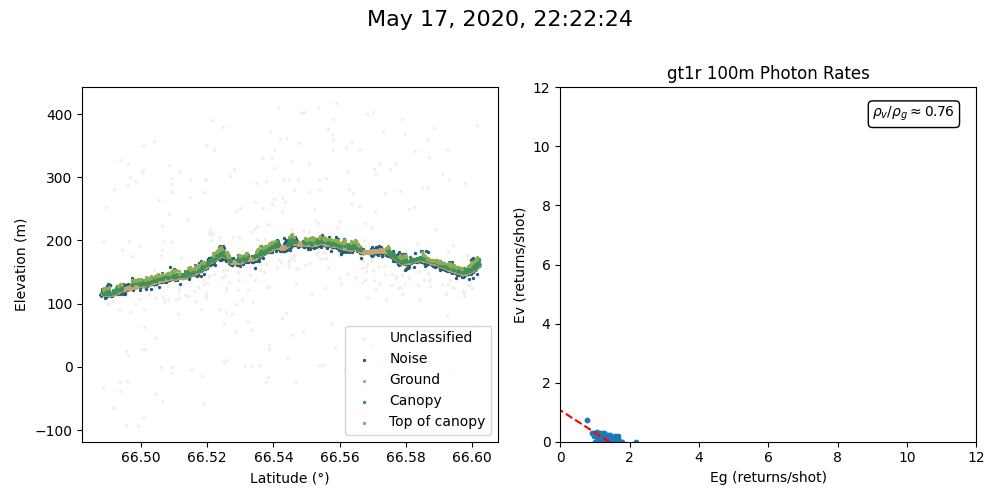

N = 14, s = 0.05


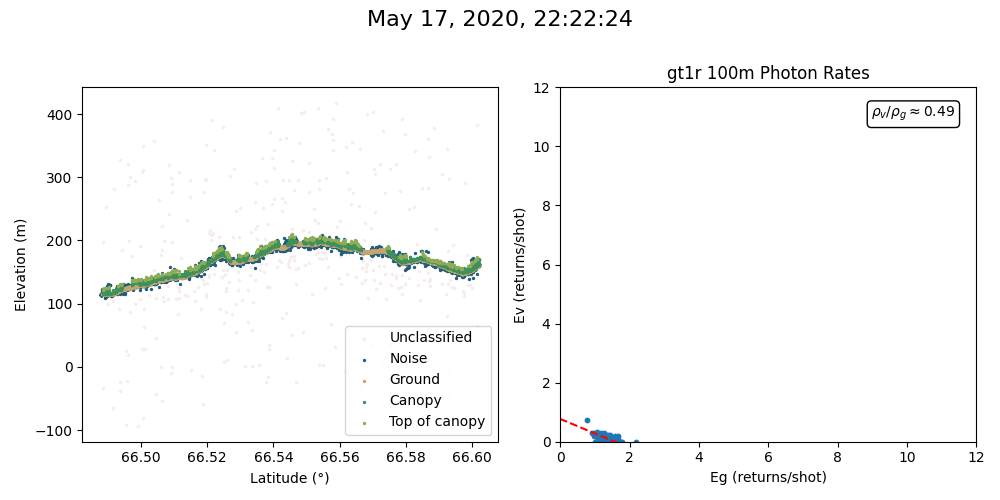

N = 14, s = 0.1


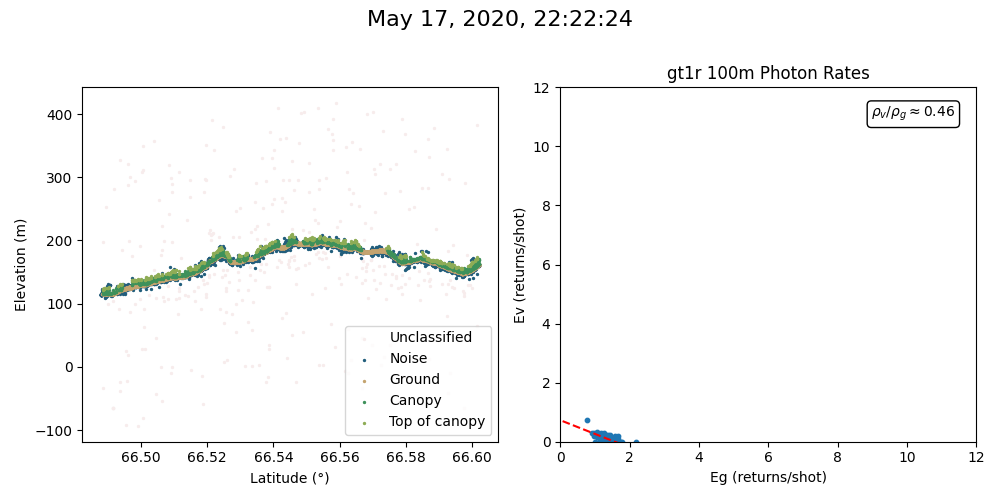

N = 15, s = 0.01


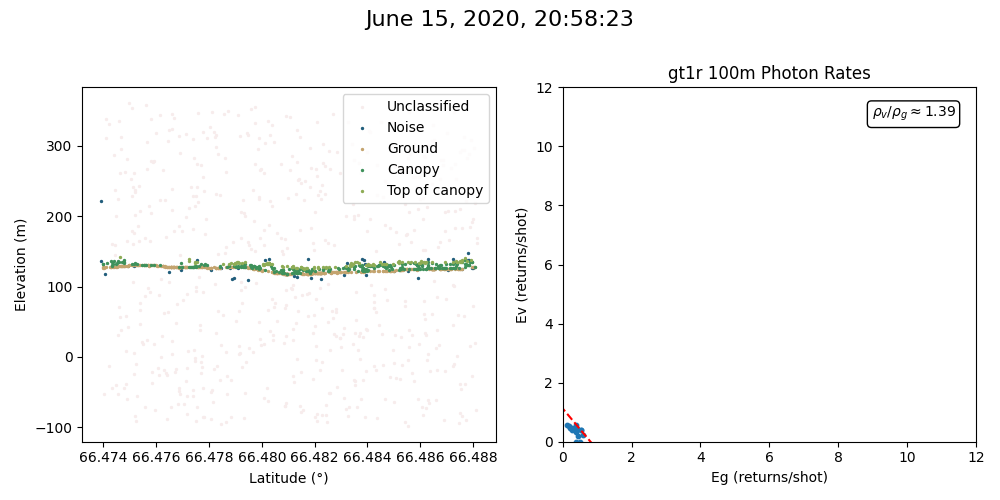

N = 15, s = 0.05


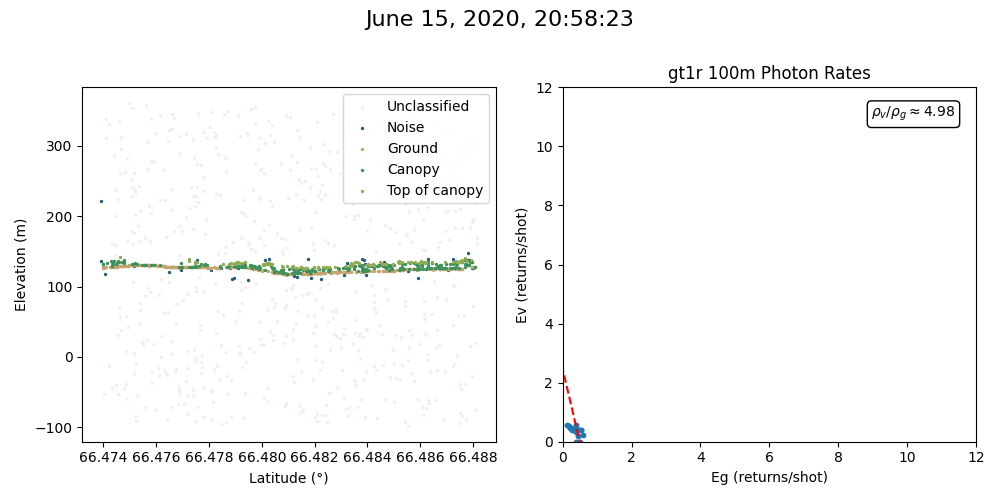

N = 15, s = 0.1


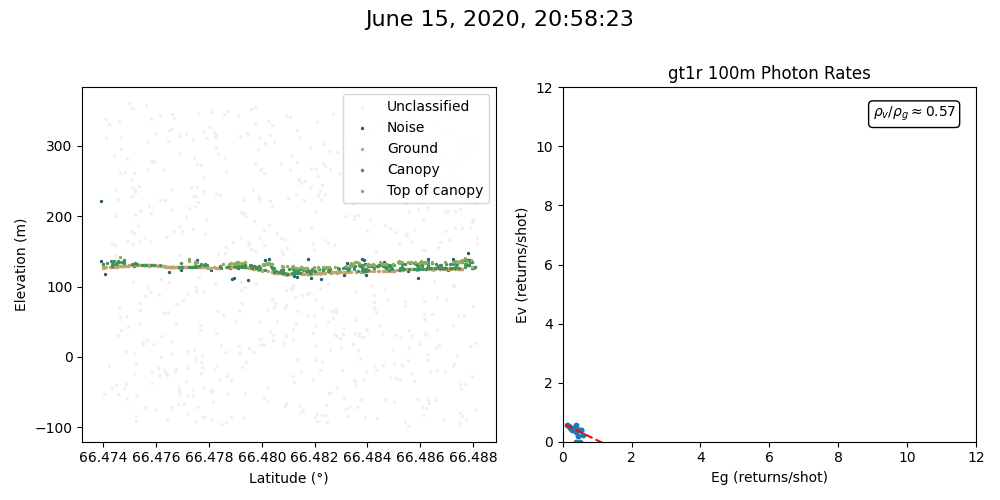

N = 16, s = 0.01


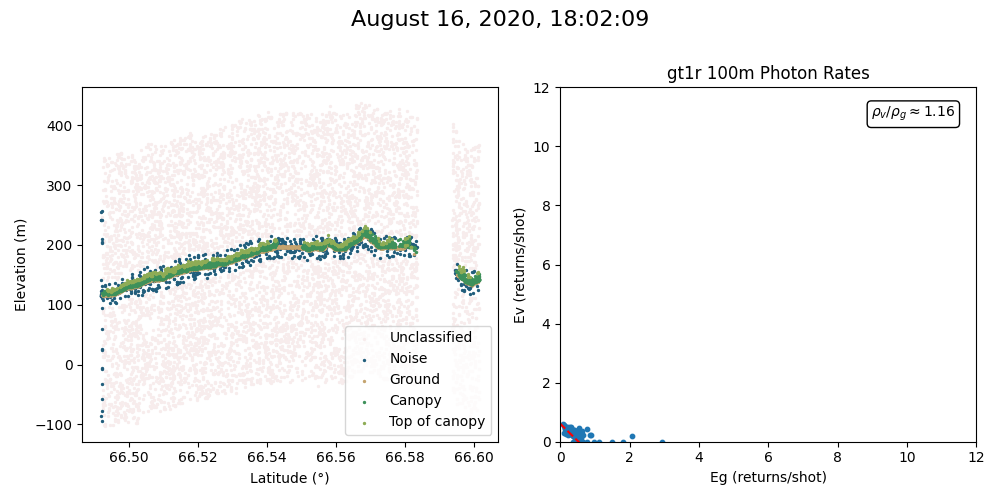

N = 16, s = 0.05


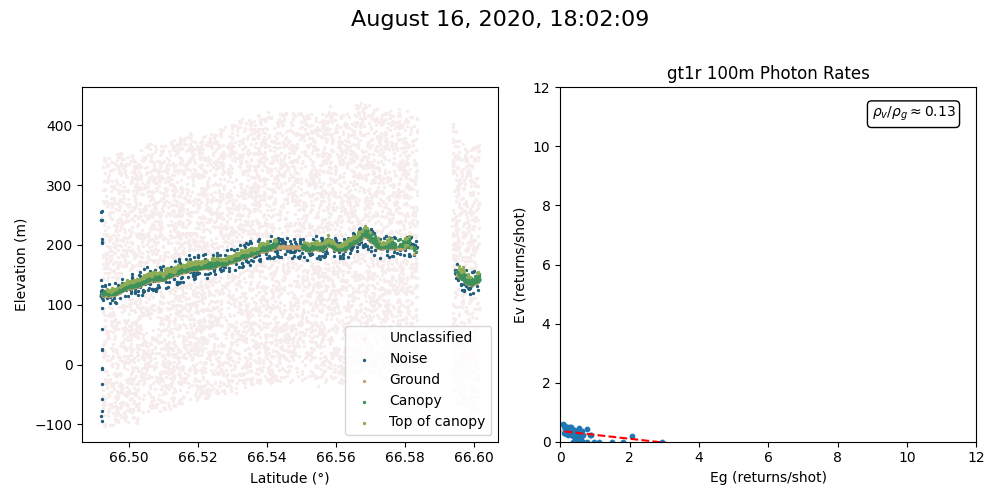

N = 16, s = 0.1


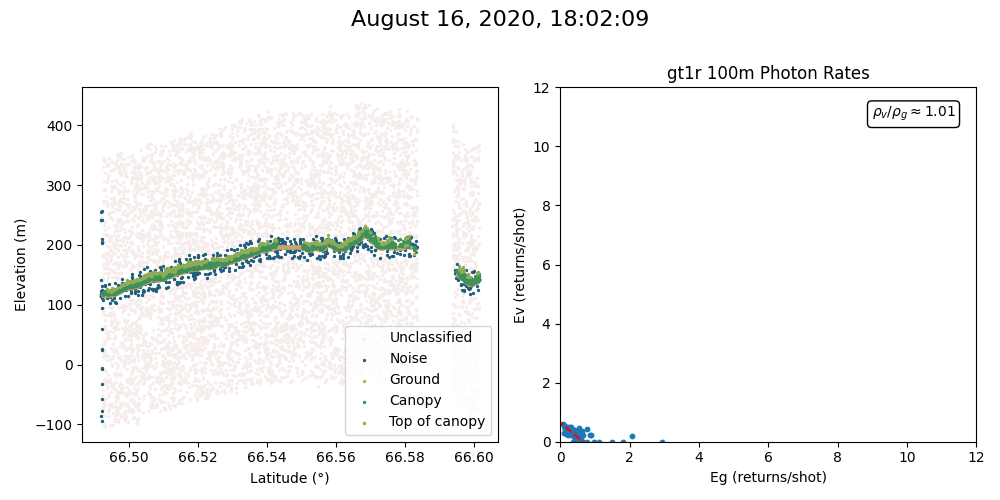

N = 17, s = 0.01


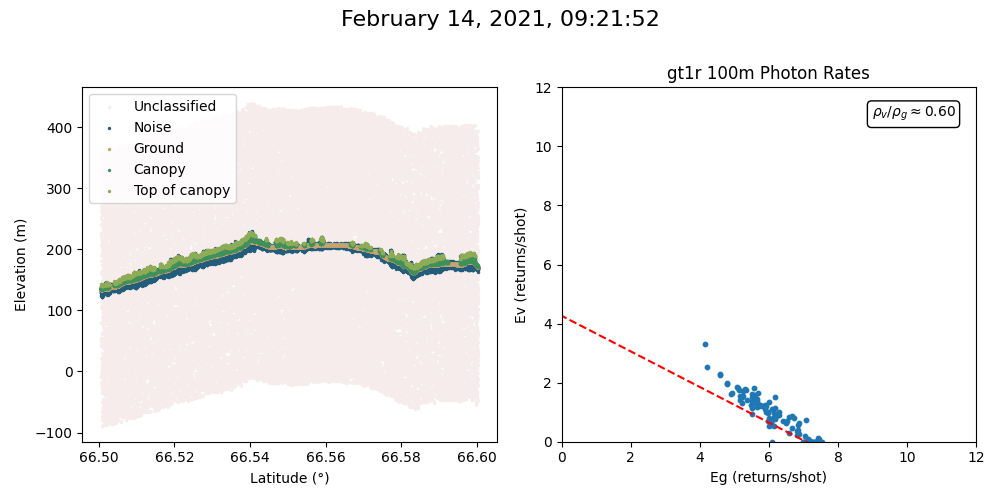

N = 17, s = 0.05


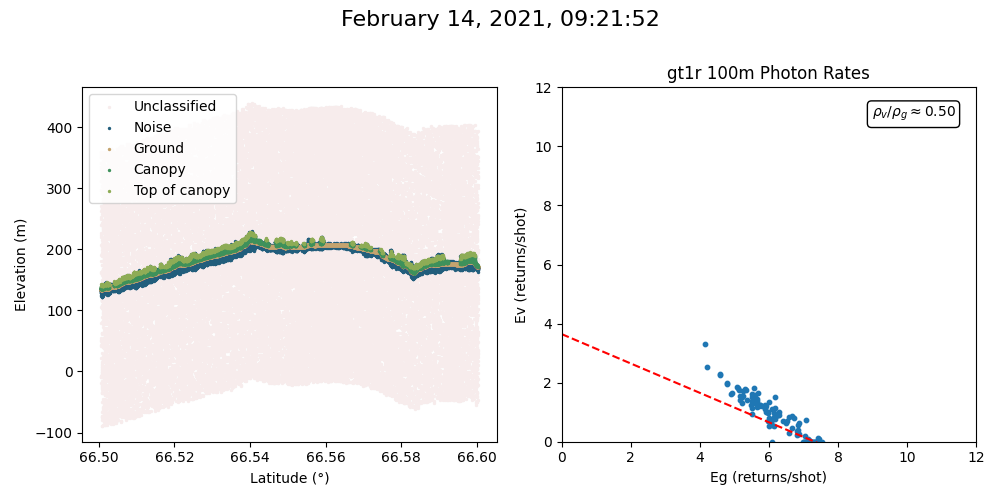

N = 17, s = 0.1


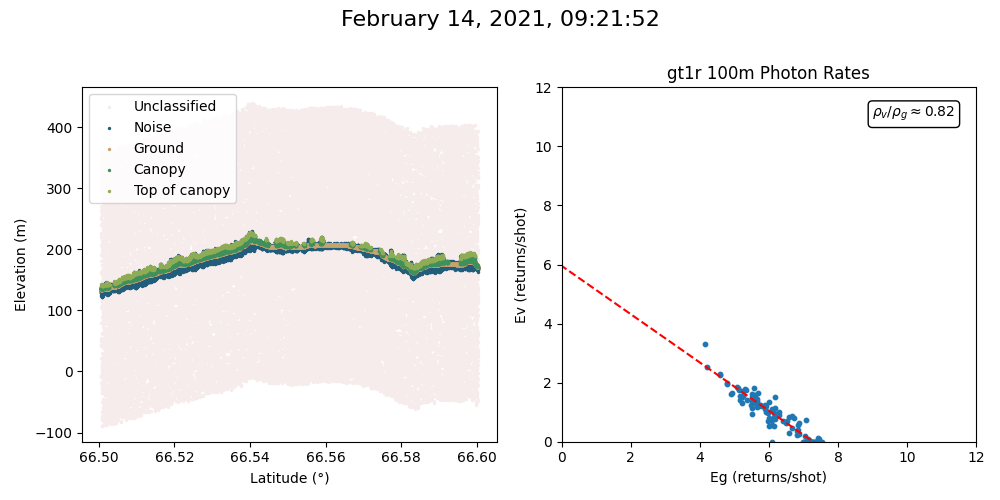

N = 18, s = 0.01
N = 18, s = 0.05
N = 18, s = 0.1
N = 19, s = 0.01
N = 19, s = 0.05
N = 19, s = 0.1
N = 20, s = 0.01
N = 20, s = 0.05
N = 20, s = 0.1


In [103]:
%matplotlib ipympl

dirpath = '../data/rovaniemi_w'
all_ATL03, all_ATL08 = track_pairs(dirpath)

# N = len(all_ATL03)
gt = 'gt1r'

N = np.arange(0,21,1)
S = [0.01,0.05,0.1]
for i in N:
    for s in S:
        print('N = ' + str(i) + ', s = ' + str(s))
        atl03path = all_ATL03[i]
        atl08path = all_ATL08[i]
        pvpg_gt_penalized(atl03path, atl08path, gt, s)